In [3]:
from glob import glob
from itertools import chain
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
LANGS = ('pt', 'en', 'fr')

#### Auxiliary Functions

In [5]:
def get_top_words(results, lang, k=300):
    min_val = n_words[lang] / k
    words = [(word, results[lang][word]) for word in results[lang] if results[lang][word] >= min_val]
    words.sort(key=lambda x: x[1], reverse=True)
    
    return words

def print_top_words(results, lang, k=300):
    words = get_top_words(results, lang, k)
    for word in words:
        print(f'{word[0]:15}:::  {word[1]} counts')
    print(f'\n\t{len(words)} words above the {1/k:.1e} ratio threshold.')

In [6]:
def plot_exact(top_words):
    fig, ax = plt.subplots(3, 1, figsize=(6, 12))
    for i, lang in enumerate(LANGS):
        plt.subplot(3, 1, i+1)
        plt.bar([word[0] for word in top_words[lang]], [word[1] for word in top_words[lang]])
        plt.xticks(rotation=45, ha='right')
        ax[i].set_ylabel('Occurences')
        ax[i].set_title(f'Language: {lang.upper()}')
    fig.tight_layout()
    
    return fig, ax

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Exact results

In [8]:
with open('./results/det_counter.pkl', 'rb') as f: 
    det_results = pickle.load(f)    

In [9]:
n_words = {lang: sum(det_results[lang].values()) for lang in LANGS}
n_words

{'pt': 31099, 'en': 24710, 'fr': 29563}

In [10]:
n_unique_words = {lang: len(det_results[lang]) for lang in LANGS}
n_unique_words

{'pt': 8965, 'en': 5927, 'fr': 8180}

In [11]:
top_words = {lang: get_top_words(det_results, lang) for lang in LANGS}

In [10]:
print_top_words(det_results, 'fr', k=300)

barbicane      :::  250 counts
mille          :::  198 counts
lune           :::  186 counts
cent           :::  170 counts
deux           :::  165 counts
maston         :::  139 counts
projectile     :::  134 counts
ardan          :::  126 counts
bien           :::  121 counts
club           :::  117 counts
gun            :::  112 counts
président      :::  110 counts
michel         :::  108 counts
terre          :::  103 counts
répondit       :::  100 counts

	15 words above the 3.3e-03 ratio threshold.


In [11]:
print_top_words(det_results, 'en')

barbicane      :::  241 counts
moon           :::  179 counts
projectile     :::  154 counts
gun            :::  138 counts
maston         :::  133 counts
said           :::  121 counts
answered       :::  121 counts
ardan          :::  121 counts
club           :::  116 counts
president      :::  108 counts
michel         :::  103 counts
feet           :::  97 counts
earth          :::  94 counts
two            :::  86 counts
made           :::  85 counts

	15 words above the 3.3e-03 ratio threshold.


In [12]:
print_top_words(det_results, 'pt')

barbicane      :::  258 counts
lua            :::  194 counts
mil            :::  153 counts
projectil      :::  148 counts
ardan          :::  145 counts
maston         :::  143 counts
club           :::  123 counts
gun            :::  116 counts
dia            :::  111 counts
presidente     :::  109 counts
miguel         :::  108 counts
terra          :::  105 counts

	12 words above the 3.3e-03 ratio threshold.


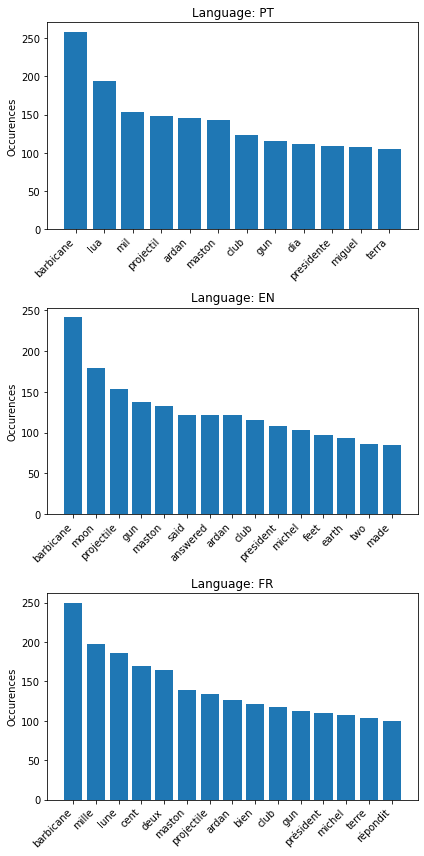

In [13]:
fig, ax = plot_exact(top_words);
fig.savefig('./plots/exact_words.png', dpi=300)

## CM Sketch

#### Auxiliary Functions

In [12]:
def plot_estim(estim_results, det_results):
    
    estim_top_words = {lang: get_top_words(estim_results, lang) for lang in LANGS}
    
    fig, ax = plt.subplots(3, 1, figsize=(6, 12))
    for i, lang in enumerate(LANGS):
        estim_word_list = [word[0] for word in estim_top_words[lang]]
        estim_counts = [word[1] for word in estim_top_words[lang]]
        real_word_list = [word[0] for word in top_words[lang]]
        real_counts = [det_results[lang][word[0]] for word in estim_top_words[lang]]
        marker_color = np.where([word in real_word_list for word in estim_word_list], '#2ca02c', '#d62728')
        
        plt.subplot(3, 1, i+1)
        plt.bar(estim_word_list, estim_counts, alpha=0.6, label='Estimated')
        plt.scatter(estim_word_list, real_counts, marker='X', s=100, color=marker_color, label='Real')
        plt.xticks(rotation=45, ha='right')
        ax[i].set_ylabel('Occurences')
        ax[i].set_title(f'Language: {lang.upper()}')
        ax[i].legend()
    fig.tight_layout()
    
    return fig, ax

In [13]:
def get_file_metrics(file_name):
    with open(file_name, 'rb') as f: 
        cm_results = pickle.load(f)
    rmses, n_wrong = {}, {}
    for lang in ('fr', 'en', 'pt'):
        top_words_cm = get_top_words(cm_results, lang)
        words = [word[0] for word in top_words_cm]
        preds = np.array([word[1] for word in top_words_cm])
        targs = np.array([det_results[lang][word] for word in words])
        rmses[lang] = rmse(preds, targs)
        n_wrong[lang] = len(top_words_cm) - len(top_words[lang])
    return rmses, n_wrong

def create_metrics_df(folder):
    data = {}
    for i, file in enumerate(sorted(glob(f'{folder}/cm_sketch*.pkl'))):
        m = int(file.split('_')[-2][-5:])
        d = int(file.split('_')[-1][2:-4])
        rmses, n_wrong = get_file_metrics(file)
        data[i] = list(chain.from_iterable([[m, d], list(rmses.values()), list(n_wrong.values())]))
    col_names = ['m', 'd', 'rmse (fr)', 'rmse (en)', 'rmse (pt)', 'n_wrong (fr)', 'n_wrong (en)', 'n_wrong (pt)']
    df = pd.DataFrame.from_dict(data, orient='index', columns=col_names)
    df.insert(5,'rmse (avg)', df.iloc[:,2:5].mean(axis=1))
    df.insert(6,'log rmse (avg)', np.log(df['rmse (avg)']))
    df.insert(10,'n_wrong (avg)', df.iloc[:,-3:].mean(axis=1))
    df.insert(11,'log n_wrong (avg)', np.log(df['n_wrong (avg)']))
    #df.insert(-1,'n_wrong (avg)', np.mean((df['n_wrong (fr)'], df['n_wrong (en)'], df['rmse (pt)']), axis=0))
    return df

In [14]:
def plot_heatmap(df, column):
    piv = pd.pivot_table(df, values=column, index=["m"], columns=["d"], fill_value=0)
    
    fig, ax = plt.subplots()
    im = ax.imshow(piv, cmap="Blues")
    fig.colorbar(im, ax=ax)
    ax.set_xticks(range(len(piv.columns)))
    ax.set_yticks(range(len(piv.index)))
    ax.set_xticklabels(piv.columns)
    ax.set_yticklabels(piv.index)
    ax.set_xlabel("d")
    ax.set_ylabel("m")

    plt.tight_layout()
    
    return fig, ax

In [15]:
def plot_fixed_param(df, column, fixed_param, fixed_val):
    assert fixed_param in ('m', 'd'), 'Fixed parameter must be "m" or "d"'
    if fixed_param == 'm':
        free_param = 'd'
    elif fixed_param == 'd':
        free_param = 'm'
    fig, ax = plt.subplots()
    df[df[fixed_param]==fixed_val].plot(x=free_param, y=column, 
                                        kind='scatter', s=30,
                                        title=f'{fixed_param} = {fixed_val}', ax=ax);   
    
    return fig, ax

### Results

In [14]:
with open('./results/cm_sketch_m=01200_d=05.pkl', 'rb') as f: 
    cm_results = pickle.load(f)    

In [ ]:
with open('./results/cm_sketch_m=00600_d=05.pkl', 'rb') as f: 
    cm_results2 = pickle.load(f)    

In [15]:
top_words_cm = {
    'fr': get_top_words(cm_results, 'fr'),
    'en': get_top_words(cm_results, 'en'),
    'pt': get_top_words(cm_results, 'pt')
}

In [17]:
print_top_words(cm_results, 'fr')

barbicane      :::  258 counts
mille          :::  200 counts
lune           :::  197 counts
cent           :::  174 counts
deux           :::  169 counts
maston         :::  147 counts
projectile     :::  140 counts
ardan          :::  132 counts
bien           :::  125 counts
club           :::  122 counts
président      :::  119 counts
michel         :::  119 counts
gun            :::  116 counts
répondit       :::  107 counts
terre          :::  106 counts
quatre         :::  103 counts
trois          :::  99 counts

	17 words above the 3.3e-03 ratio threshold.


In [11]:
n_words['fr']/300

98.54333333333334

In [10]:
det_results['fr']['quatre'], det_results['fr']['trois'] 

(98, 89)

In [18]:
print_top_words(cm_results, 'en')

barbicane      :::  248 counts
moon           :::  182 counts
projectile     :::  158 counts
gun            :::  142 counts
maston         :::  135 counts
said           :::  126 counts
ardan          :::  125 counts
answered       :::  124 counts
club           :::  123 counts
president      :::  112 counts
michel         :::  109 counts
feet           :::  104 counts
earth          :::  97 counts
two            :::  91 counts
made           :::  88 counts
cannon         :::  87 counts
well           :::  86 counts

	17 words above the 3.3e-03 ratio threshold.


In [14]:
n_words['en']/300

82.36666666666666

In [16]:
det_results['en']['cannon'], det_results['en']['well'] 

(82, 78)

In [19]:
print_top_words(cm_results, 'pt')

barbicane      :::  264 counts
lua            :::  199 counts
mil            :::  161 counts
ardan          :::  156 counts
projectil      :::  156 counts
maston         :::  146 counts
club           :::  127 counts
presidente     :::  121 counts
gun            :::  121 counts
miguel         :::  120 counts
dia            :::  120 counts
terra          :::  114 counts

	12 words above the 3.3e-03 ratio threshold.


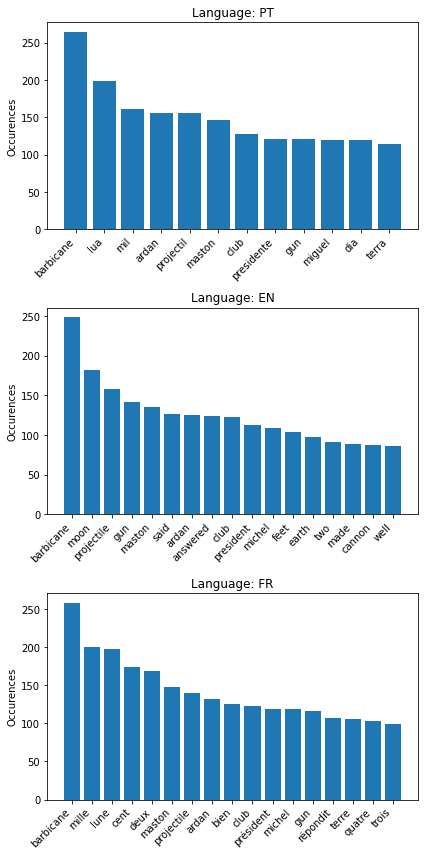

In [20]:
fig, ax = plot_exact(top_words_cm)

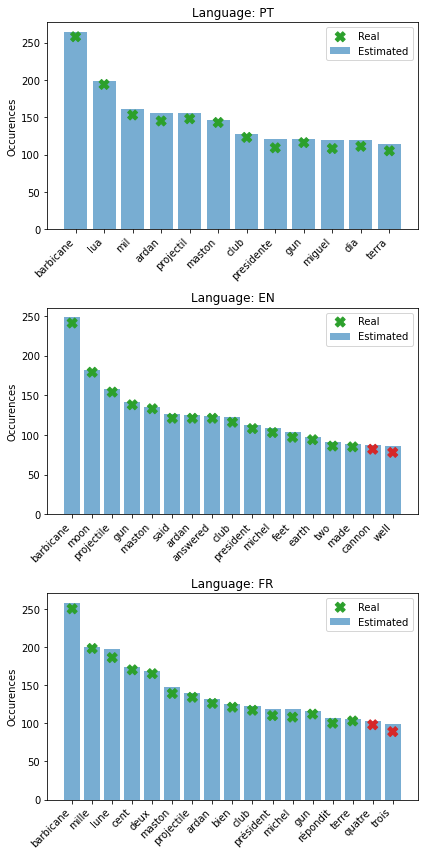

In [254]:
fig, ax = plot_estim(cm_results, det_results);
fig.savefig('./plots/estim_words.png', dpi=300)

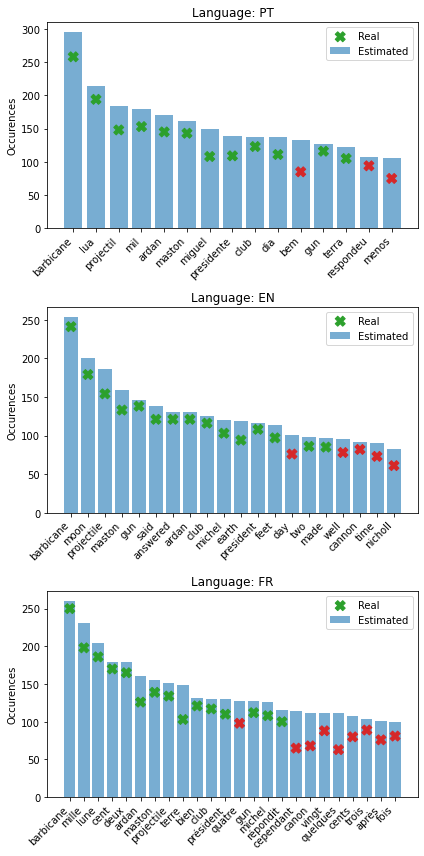

In [257]:
fig, ax = plot_estim(cm_results2, det_results);
#fig.savefig('./plots/estim_words.png', dpi=300)

In [134]:
rmses, n_wrongs = get_file_metrics('./results/cm_sketch_m=01200_d=05.pkl')
for lang in LANGS:
    print(f'{lang.upper()} :: RMSE = {rmses[lang]:.2f}, n_wrong = {n_wrongs[lang]:.2f}',)

PT :: RMSE = 8.22
EN :: RMSE = 5.01
FR :: RMSE = 6.86


In [329]:
df = create_metrics_df('./results/')
df

/home/tiago/anaconda3/envs/Algoritmos/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
0,12,1,2468.464049,2086.483493,2606.630105,2387.192549,7.777873,7924,5748,8661,7444.333333,8.915208
1,12,2,2342.292505,1917.597323,2450.942797,2236.944209,7.712866,7899,5733,8630,7420.666667,8.912024
2,12,3,2293.234294,1858.668768,2386.541199,2179.481420,7.686842,7891,5728,8619,7412.666667,8.910946
3,12,4,2253.626884,1816.078096,2328.399980,2132.701653,7.665145,7884,5727,8606,7405.666667,8.910001
4,12,5,2208.031478,1790.681198,2303.488603,2100.733760,7.650042,7877,5719,8604,7400.000000,8.909235
...,...,...,...,...,...,...,...,...,...,...,...,...
125,12000,6,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
126,12000,7,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
127,12000,8,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
128,12000,9,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf


In [160]:
df[df['m']==12]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
0,12,1,2468.464049,2086.483493,2606.630105,2387.192549,7.777873,7924,5748,8661,7444.333333,8.915208
1,12,2,2342.292505,1917.597323,2450.942797,2236.944209,7.712866,7899,5733,8630,7420.666667,8.912024
2,12,3,2293.234294,1858.668768,2386.541199,2179.481420,7.686842,7891,5728,8619,7412.666667,8.910946
3,12,4,2253.626884,1816.078096,2328.399980,2132.701653,7.665145,7884,5727,8606,7405.666667,8.910001
4,12,5,2208.031478,1790.681198,2303.488603,2100.733760,7.650042,7877,5719,8604,7400.000000,8.909235
5,12,6,2199.072467,1770.895541,2264.523146,2078.163718,7.639240,7871,5712,8597,7393.333333,8.908334
6,12,7,2186.345239,1755.662287,2257.967533,2066.658353,7.633688,7870,5711,8592,7391.000000,8.908018
7,12,8,2167.645090,1741.282031,2248.663294,2052.530138,7.626829,7868,5705,8592,7388.333333,8.907657
8,12,9,2161.468033,1733.540698,2245.162433,2046.723721,7.623996,7866,5695,8589,7383.333333,8.906980
9,12,10,2159.562682,1721.443607,2238.605451,2039.870580,7.620642,7865,5694,8589,7382.666667,8.906890


In [170]:
df[df['m']==600]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
40,600,1,155.238814,129.784365,147.987840,144.337006,4.972151,309,254,280,281.000000,5.638355
41,600,2,76.605803,63.659785,81.369928,73.878505,4.302422,34,29,34,32.333333,3.476099
42,600,3,42.524111,29.637314,45.551213,39.237546,3.669634,15,12,11,12.666667,2.538974
43,600,4,28.504035,18.984956,40.051217,29.180069,3.373486,10,6,8,8.000000,2.079442
44,600,5,26.771409,17.677670,28.344312,24.264463,3.189013,9,5,3,5.666667,1.734601
45,600,6,23.642261,16.040574,24.911271,21.531369,3.069511,8,5,2,5.000000,1.609438
46,600,7,18.870486,14.941993,24.767490,19.526656,2.971781,6,4,2,4.000000,1.386294
47,600,8,18.682880,13.688259,22.012983,18.128041,2.897460,5,4,2,3.666667,1.299283
48,600,9,17.489997,12.682354,22.012983,17.395111,2.856189,5,4,2,3.666667,1.299283
49,600,10,15.749687,12.550949,21.743636,16.681424,2.814296,4,4,2,3.333333,1.203973


In [294]:
df[df['m']==1200]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
60,1200,1,135.664454,123.502235,144.189782,134.452157,4.901208,94,81,63,79.333333,4.373658
61,1200,2,30.369392,43.409676,34.482915,36.087328,3.585942,5,5,2,4.000000,1.386294
62,1200,3,7.688800,17.605239,11.405127,12.233055,2.504142,2,3,1,2.000000,0.693147
63,1200,4,7.166097,5.871166,9.976896,7.671386,2.037497,2,2,1,1.666667,0.510826
64,1200,5,6.855655,5.005879,8.215838,6.692457,1.900981,2,2,0,1.333333,0.287682
65,1200,6,6.855655,4.916957,8.215838,6.662817,1.896542,2,2,0,1.333333,0.287682
66,1200,7,6.118619,4.582576,8.215838,6.305678,1.841450,1,2,0,1.000000,0.000000
67,1200,8,5.825590,3.963065,7.123903,5.637519,1.729444,1,2,0,1.000000,0.000000
68,1200,9,5.825590,3.842487,6.806859,5.491645,1.703228,1,2,0,1.000000,0.000000
69,1200,10,5.825590,3.741657,6.806859,5.458036,1.697089,1,2,0,1.000000,0.000000


In [169]:
df[df['m']==1500]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
70,1500,1,142.147009,121.184701,136.073665,133.135125,4.891365,64,67,59,63.333333,4.148412
71,1500,2,17.355755,35.187468,41.428079,31.323767,3.444377,3,4,2,3.000000,1.098612
72,1500,3,6.837397,5.167773,10.054021,7.353064,1.995117,1,2,0,1.000000,0.000000
73,1500,4,5.947689,5.162079,9.242114,6.783960,1.914561,1,2,0,1.000000,0.000000
74,1500,5,5.425634,5.110543,7.494442,6.010206,1.793459,1,2,0,1.000000,0.000000
75,1500,6,5.267827,5.017616,5.454356,5.246600,1.657580,1,2,0,1.000000,0.000000
76,1500,7,4.190764,3.970479,5.354126,4.505123,1.505215,1,2,0,1.000000,0.000000
77,1500,8,4.130678,2.968586,5.196152,4.098472,1.410614,1,1,0,0.666667,-0.405465
78,1500,9,3.992180,2.645751,4.974937,3.870956,1.353502,1,1,0,0.666667,-0.405465
79,1500,10,3.605551,2.645751,4.072264,3.441189,1.235817,1,1,0,0.666667,-0.405465


In [171]:
df[df['m']==12000]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
120,12000,1,76.509029,78.607221,90.265042,81.793764,4.404201,4,6,6,5.333333,1.673976
121,12000,2,2.435843,1.095445,1.190238,1.573842,0.453520,0,0,0,0.000000,-inf
122,12000,3,0.258199,0.258199,0.707107,0.407835,-0.896893,0,0,0,0.000000,-inf
123,12000,4,0.000000,0.000000,0.408248,0.136083,-1.994492,0,0,0,0.000000,-inf
124,12000,5,0.000000,0.000000,0.288675,0.096225,-2.341066,0,0,0,0.000000,-inf
125,12000,6,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
126,12000,7,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
127,12000,8,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
128,12000,9,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf
129,12000,10,0.000000,0.000000,0.000000,0.000000,-inf,0,0,0,0.000000,-inf


### Metrics Heatmaps

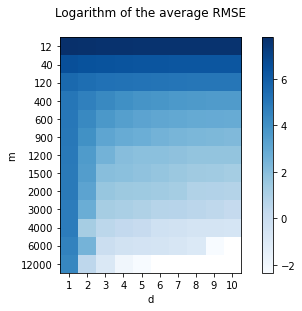

In [158]:
fig, ax = plot_heatmap(df, 'log rmse (avg)')
ax.set_title('Logarithm of the average RMSE\n');
fig.savefig('./plots/heatmap_rmse.png', bbox_inches='tight', dpi=300)

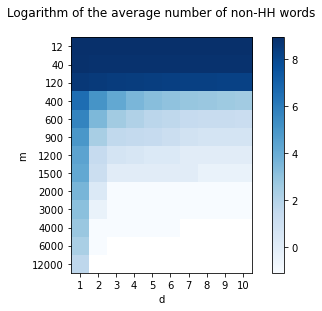

In [157]:
fig, ax = plot_heatmap(df, 'log n_wrong (avg)')
ax.set_title('Logarithm of the average number of non-HH words\n');
fig.savefig('./plots/heatmap_wrong.png', bbox_inches='tight', dpi=300)

### Fixed parameters plots

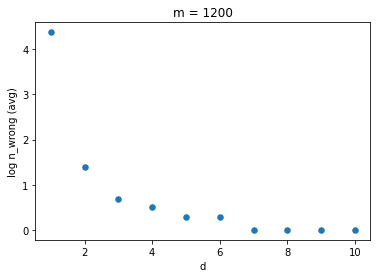

In [271]:
fig, ax = plot_fixed_param(df, 'log n_wrong (avg)', 'm', 1200)
fig.savefig('./plots/fixed_m_wrong.png', dpi=300)

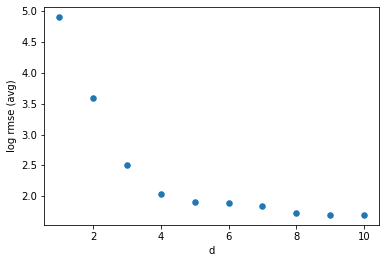

In [272]:
fig, ax = plot_fixed_param(df, 'log rmse (avg)', 'm', 1200)
ax.set_title('');
fig.savefig('./plots/fixed_m_rmse.png', dpi=300)

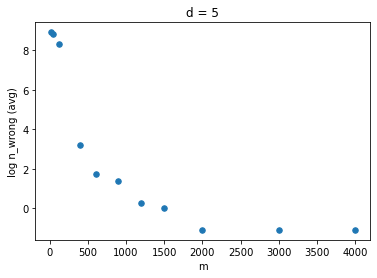

In [275]:
fig, ax = plot_fixed_param(df, 'log n_wrong (avg)', 'd', 5);
fig.savefig('./plots/fixed_d_wrong.png', dpi=300)

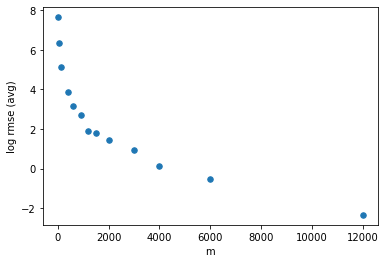

In [277]:
fig, ax = plot_fixed_param(df, 'log rmse (avg)', 'd', 5);
ax.set_title('');
fig.savefig('./plots/fixed_d_rmse.png', dpi=300)

### Constraint queries

In [304]:
filt = (df['rmse (en)']<=20) & (df['d'] * df['m'] <= n_words['en']/8)
df.loc[filt]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
43,600,4,28.504035,18.984956,40.051217,29.180069,3.373486,10,6,8,8.000000,2.079442
44,600,5,26.771409,17.677670,28.344312,24.264463,3.189013,9,5,3,5.666667,1.734601
52,900,3,19.669774,16.614616,29.518759,21.934383,3.088055,5,7,2,4.666667,1.540445


In [320]:
filt = (df['rmse (en)']<=10) & (df['d'] * df['m'] <= n_words['en']/5)
df.loc[filt]

,m,d,rmse (fr),rmse (en),rmse (pt),rmse (avg),log rmse (avg),n_wrong (fr),n_wrong (en),n_wrong (pt),n_wrong (avg),log n_wrong (avg)
63,1200,4,7.166097,5.871166,9.976896,7.671386,2.037497,2,2,1,1.666667,0.510826
72,1500,3,6.837397,5.167773,10.054021,7.353064,1.995117,1,2,0,1.000000,0.000000
